In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.cnn.dataset import GeneDataset
from src.cnn.models  import Zrimec2020c

from src.cnn import core    as cnn_core
from src.cnn import dataset as cnn_dataset
from src.cnn import model   as cnn_model
from src.cnn import plot    as cnn_plot
from src.cnn import util    as cnn_util
from src.io  import loader  as data_loader

# 1. Setup

In [3]:
# Setup some directory paths.

OUT_SUBFOLDER = 'nbp06-zrimec2020c'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
OUT_MODEL = os.path.join(OUT, 'model', OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_MODEL = os.path.join(RES, 'model', RES_SUBFOLDER)
RES_NBP04 = os.path.join(OUT, 'data', 'nbp04-feature')
RES_NBP05 = os.path.join(OUT, 'data', 'nbp05-target')

shutil.rmtree(OUT_PLOT,  ignore_errors = True)
shutil.rmtree(OUT_MODEL, ignore_errors = True)

os.makedirs(OUT_PLOT,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Device

DEVICE = cnn_core.get_device(only_cpu = False)

Graphic devices : 1
Selected device : cuda


In [5]:
# Load the input <gene> features

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_label = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-labels.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

# 2. Classification

In [6]:
# Define basic data parameters

config = {
	'random_seed' : None,
	'batch_size' : {
		'train' : 64,
		'valid' : 64,
		'test'  : 64
	},
	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0'  : 'tissue',
		'group1'  : 'tissue-mean',
		'length'  : 8,
		'classes' : 5
	}
}

# Ensure correct
config['output']['length']  = len(tpm_order[config['output']['group0']])

In [7]:
# Lock random

config['random_seed'] = cnn_core.lock_random(
	seed = config['random_seed'],
	generate_seed = True
)

print('Random seed : {}'.format(config['random_seed']))

Random seed : 197703395


## 2.1 Data

In [8]:
# Get the correct output group

gene_targets = {
	key : numpy.array(value[config['output']['group1']], dtype = numpy.int64)
	for key, value in tpm_label.items()
}

In [9]:
# Update number of classes

classes = set(numpy.array([x for x in gene_targets.values()]).flatten())

print(f'Classes Length : {len(classes)}')
print(f'Classes Unique : ' + ', '.join(str(x) for x in classes))

config['output']['classes'] = len(classes)

Classes Length : 10
Classes Unique : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9


In [10]:
# Transform the data dictionaries into lists

names = sorted(list(gene_sequences.keys()))

sequences = numpy.array([gene_sequences[key] for key in names])
features  = numpy.array([gene_frequency[key] for key in names])
targets   = numpy.array([gene_targets[key]   for key in names])

In [11]:
# Create the dataset and generte split indices using sklearn

dataset = GeneDataset(
	names       = names,
	sequences   = sequences,
	features    = features,
	targets     = targets,
	expand_dims = None
)

train_idx, valid_idx, test_idx = cnn_dataset.generate_split_indices(
	targets     = targets,
	valid_split = config['split_size']['valid'],
	test_split  = config['split_size']['test'],
	random_seed = config['random_seed']
)

In [12]:
# Create train dataloader and display batch dimensions

train_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = train_idx,
	batch_size = config['batch_size']['train']
)

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size']['train']
)

Dataloader  batch  size :     64
Dataloader  batch count :    316
Dataloader sample count : 20,224

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [13]:
# Create valid dataloader and display batch dimensions

valid_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = valid_idx,
	batch_size = config['batch_size']['valid']
)

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size']['valid']
)

Dataloader  batch  size :     64
Dataloader  batch count :     79
Dataloader sample count :  5,056

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [14]:
# Create test dataloader and display batch dimensions

test_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = test_idx,
	batch_size = config['batch_size']['test']
)

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size']['test']
)

Dataloader  batch  size :     64
Dataloader  batch count :     99
Dataloader sample count :  6,336

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


## 2.2 Model

### 2.2.1 Structure

In [15]:
# Create and display the model structure

model = Zrimec2020c(params = {
	'other' : {
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.1
	},
	'conv1' : {
		'filters' : 32,
		'kernel'  : 41,
		'padding' : 'none'
	},
	'conv2' : {
		'filters' : 128,
		'kernel'  : 41,
		'padding' : 'same'
	},
	'conv3' : {
		'filters' : 128,
		'kernel'  : 11,
		'padding' : 'same'
	},
	'maxpool1' : {
		'kernel'  : 9,
		'padding' : 'same'
	},
	'maxpool2' : {
		'kernel'  : 3,
		'padding' : 'same'
	},
	'maxpool3' : {
		'kernel'  : 9,
		'padding' : 'same'
	},
	'fc1' : {
		'features' : 256
	},
	'fc2' : {
		'features' : 512
	},
	'fc3' : {
		'features' : config['output']['classes'],
		'heads'    : config['output']['length']
	}
})

model.summary(
	batch_size  = config['batch_size']['train'],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020c                              [64, 4, 2150]             [64, 10, 8]               --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 512]                 --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 32, 2110]            5,280
│    └─ReLU: 2-2                         [64, 32, 2110]            [64, 32, 2110]            --
│    └─BatchNorm1d: 2-3                  [64, 32, 2110]            [64, 32, 2110]            64
│    └─Dropout: 2-4                      [64, 32, 2110]            [64, 32, 2110]            --
│    └─MaxPool1d: 2-5                    [64, 32, 2110]            [64, 32, 422]             --
│    └─Conv1d: 2-6                       [64, 32, 422]             [64, 128, 422]            168,064
│    └─ReLU: 2-7                         [64, 128, 422]            [64, 128, 422]            --
│    └─BatchNorm1d: 2-8    

In [16]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

### 2.2.2 Parameters

In [17]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'entropy',
	reduction = 'mean',
	weights   = None
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 0.001,
	betas        = (0.900, 0.999),
	weight_decay = 0.05
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 5,
	factor    = 0.5,
	min_lr    = 1e-8
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : 10,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : False,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		'entropy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
		'accuracy' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy')
	}
}

## 2.3 Training

In [18]:
# Train and validate the model

report = cnn_model.train_classifier(
	model  = model,
	params = params
)

### 2.3.1 Visualization

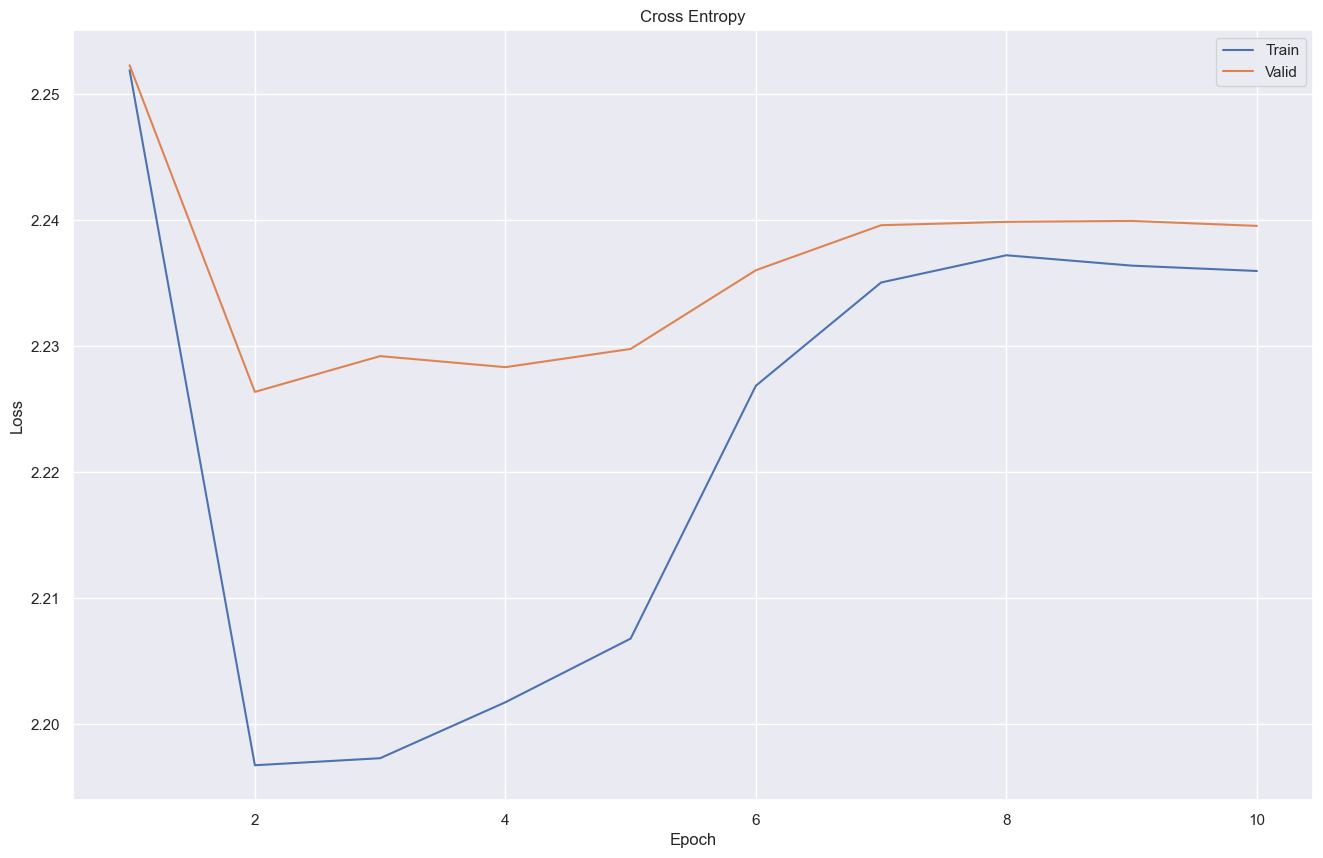

In [19]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'Cross Entropy',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

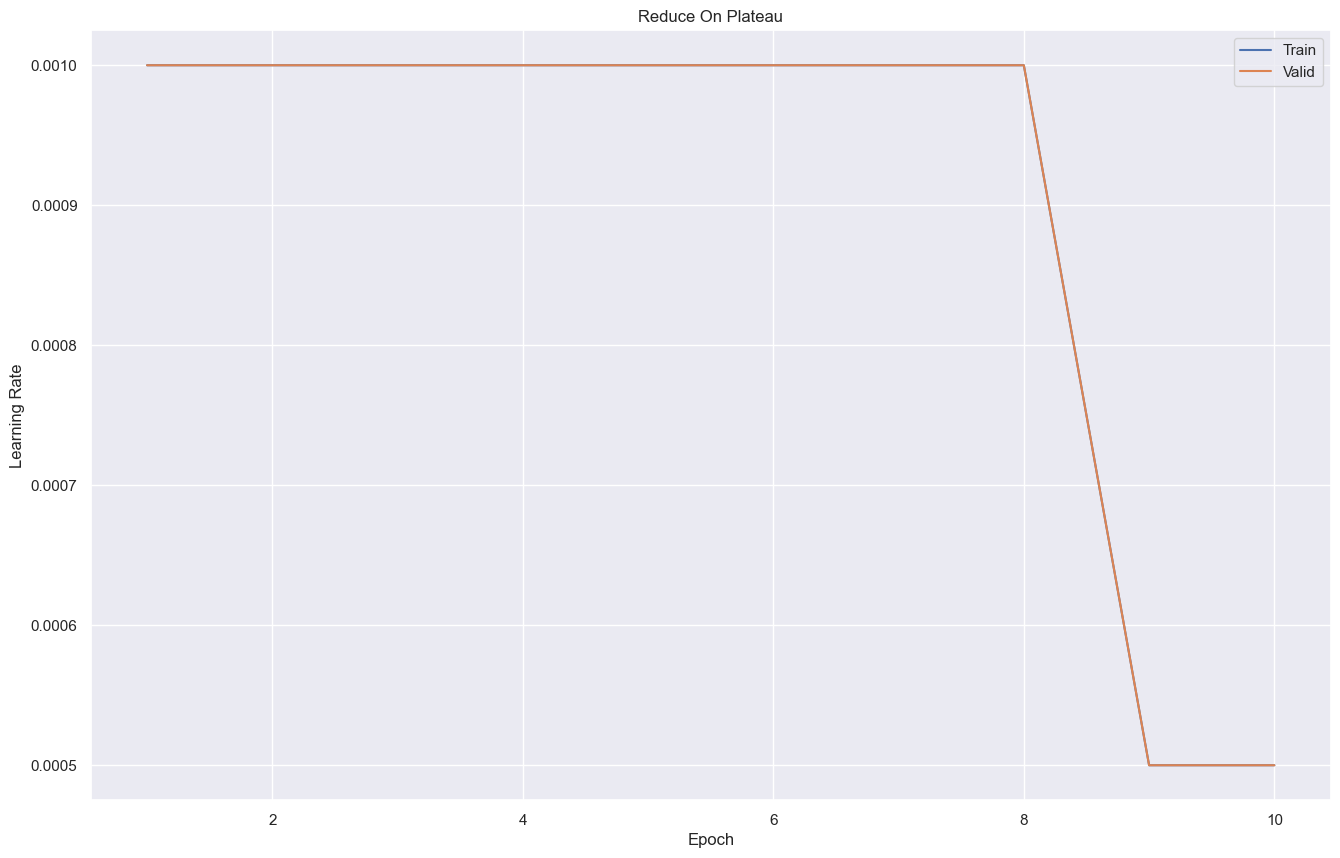

In [20]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

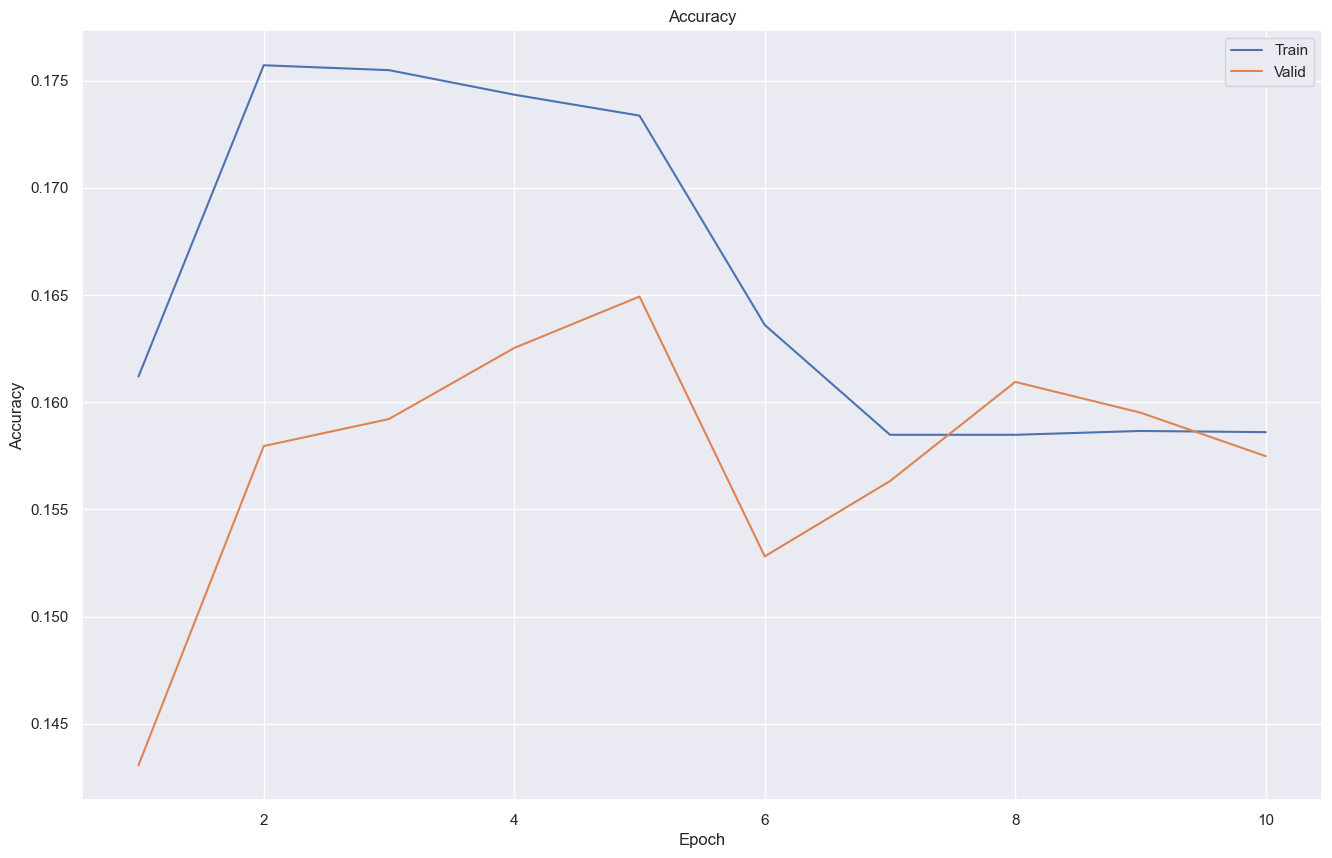

In [21]:
# Display the training and validation learning rate curves

cnn_plot.show_accuracy(
	report   = report,
	title    = 'Accuracy',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

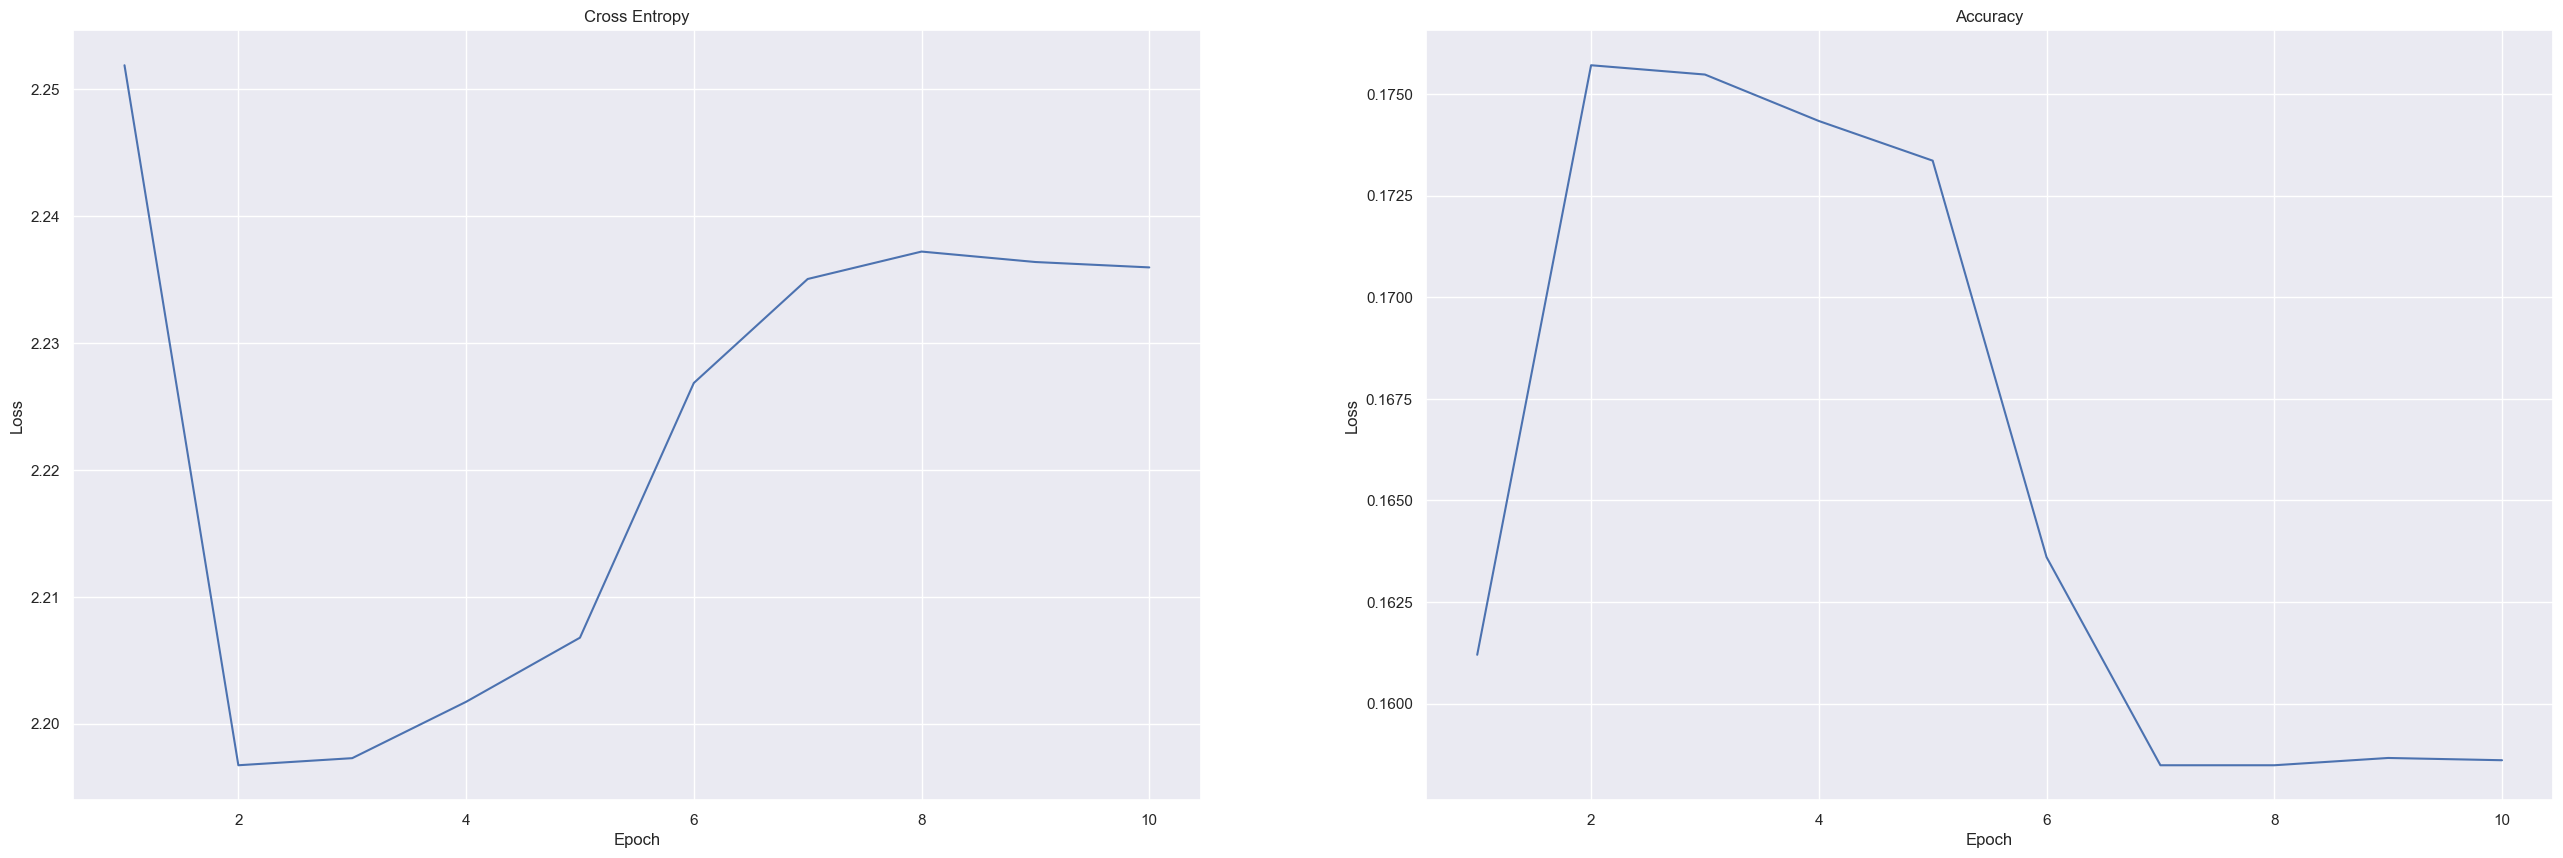

In [22]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

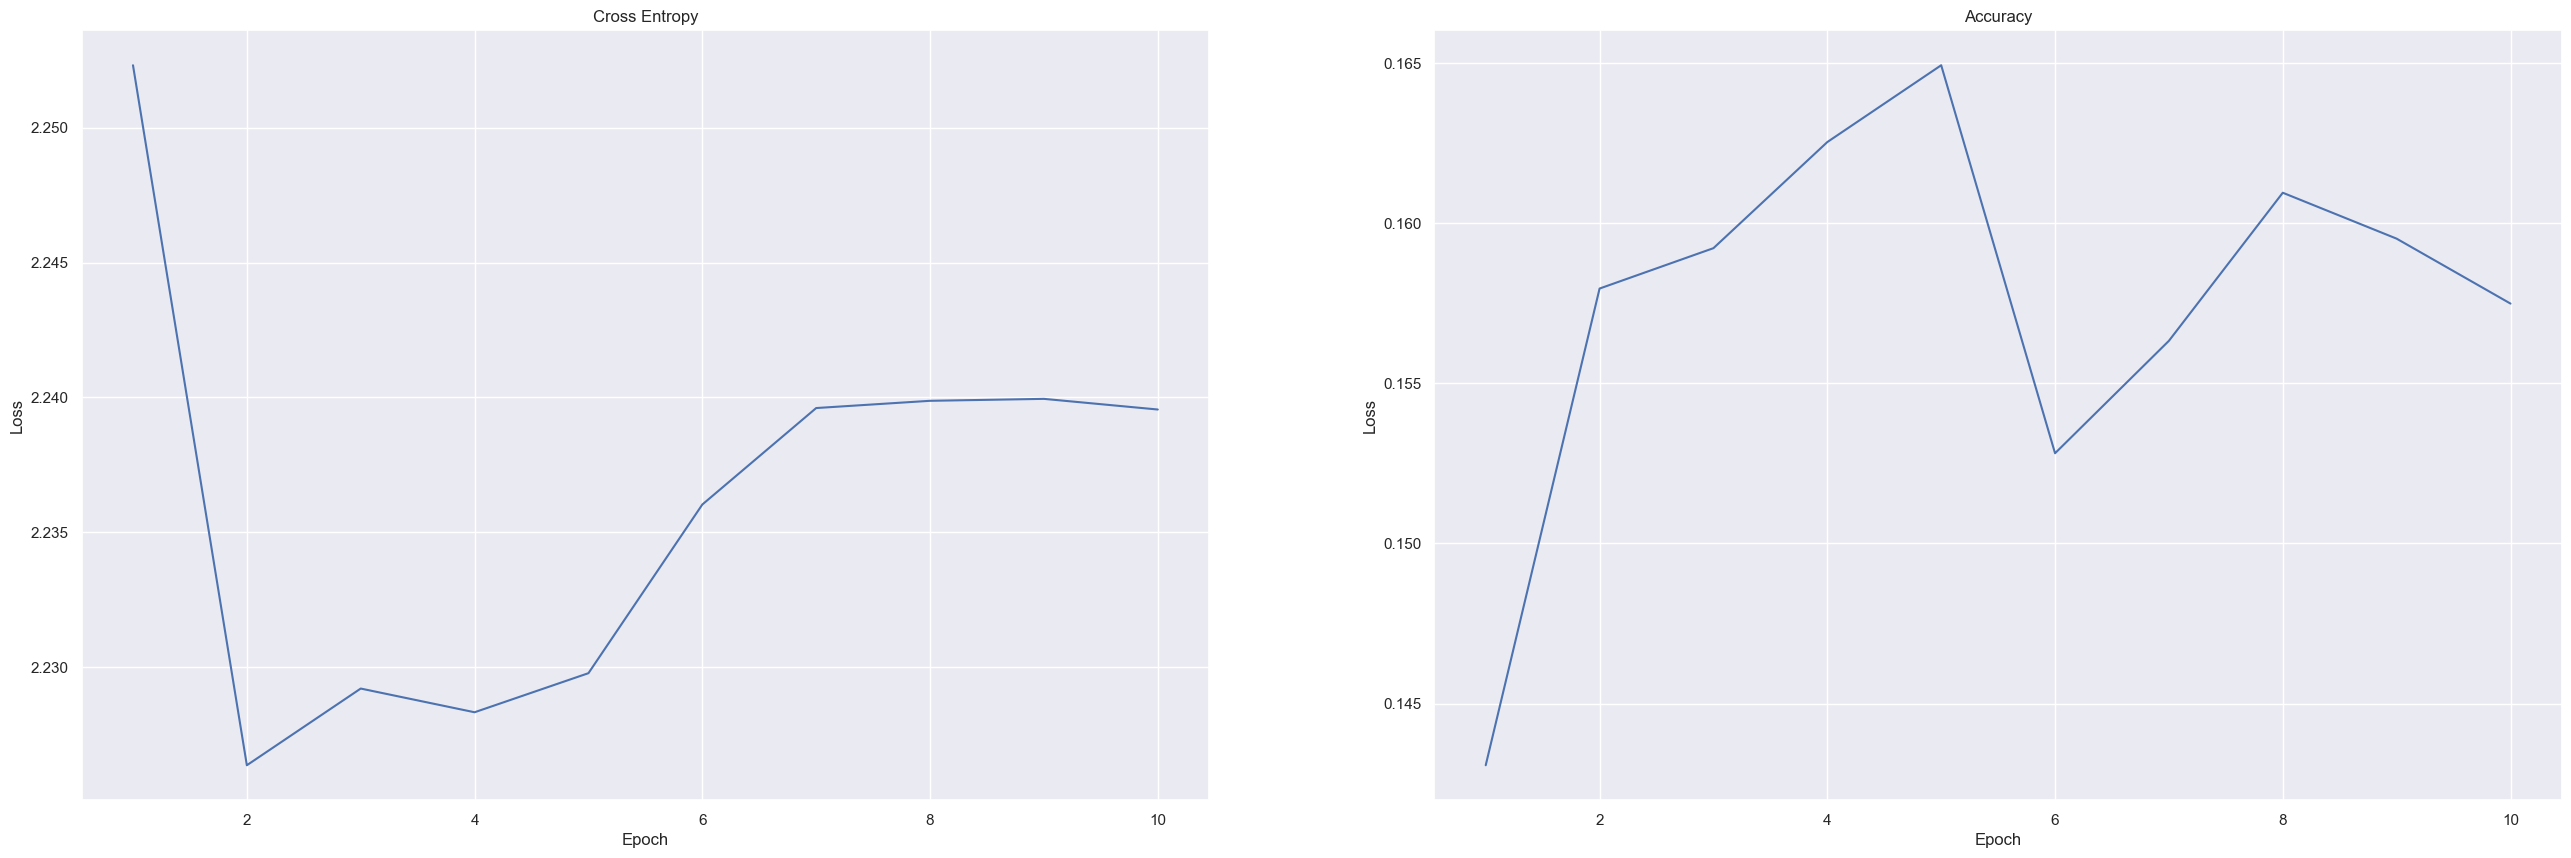

In [23]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

## 2.4 Evaluation

### 2.4.1 Last Model

In [24]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 10
 Loss : 2.23955


<All keys matched successfully>

In [25]:
# Evaluate the full model

report = cnn_model.eval_classifier(
	model  = model,
	params = params
)

In [26]:
# Print the evaluation metrics

print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))
print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))

Entropy  :  2.24072
Accuracy :  0.15988


In [27]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_classification_predictions(report = report, n = 2)

Gene     : AT3G57810.2
True     : [9 7 7 7 8 7 6 1]
Pred     : [9 9 7 9 9 9 0 1]
Entropy  : [1.76544   2.21132   2.11130   2.15126   2.11701   2.20198   2.14753   1.63780]
Accuracy : [1.00000   0.00000   1.00000   0.00000   0.00000   0.00000   0.00000   1.00000]

Gene     : AT1G16810.1
True     : [4 3 2 4 4 3 3 1]
Pred     : [9 9 7 9 9 9 0 1]
Entropy  : [2.38215   2.36856   2.31918   2.40813   2.31130   2.34362   2.35922   1.65492]
Accuracy : [0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   1.00000]



In [28]:
# Display the evaluation accuracy

dataframe = cnn_util.display_classification_accuracy(
	report = report['eval'],
	order  = tpm_order[config['output']['group0']]
).sort_values('Accuracy', ascending = False)

print('Average Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print('Average Missed 1 : {:8.5f} %'.format(dataframe['Missed_1'].mean()))
print('Average Missed 2 : {:8.5f} %'.format(dataframe['Missed_2'].mean()))
print('Average Missed 3 : {:8.5f} %'.format(dataframe['Missed_3'].mean()))
print('Average Missed 4 : {:8.5f} %'.format(dataframe['Missed_4'].mean()))
print()

dataframe

Average Accuracy : 15.98801 %
Average Missed 1 : 16.54238 %
Average Missed 2 : 12.06597 %
Average Missed 3 : 10.40878 %
Average Missed 4 :  9.85638 %



,Group,Total,Accuracy,Missed_1,Missed_2,Missed_3,Missed_4
7,senescence_reproductive,6336,26.152,33.112,10.290,10.275,8.917
0,flower,6336,20.439,15.073,11.758,10.638,9.107
3,root,6336,16.682,13.842,11.316,10.369,9.170
5,seedling,6336,14.315,12.626,11.884,10.417,10.559
6,senescence_green,6336,13.842,11.143,10.417,10.022,10.653
2,other,6336,13.100,23.201,19.539,11.001,10.417
4,seed,6336,12.342,12.200,11.032,10.496,10.243
1,leaf,6336,11.032,11.143,10.290,10.054,9.785


### 2.4.2 Best Model

In [29]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 2
 Loss : 2.22638


<All keys matched successfully>

In [30]:
# Evaluate the full model

report = cnn_model.eval_classifier(
	model  = model,
	params = params
)

In [31]:
# Print the evaluation metrics

print('Entropy  : ' + '{: 8.5f}'.format(report['eval']['metric']['entropy'].mean()))
print('Accuracy : ' + '{: 8.5f}'.format(report['eval']['metric']['accuracy'].mean()))

Entropy  :  2.22698
Accuracy :  0.15883


In [32]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_classification_predictions(report = report, n = 2)

Gene     : AT5G37630.1
True     : [7 4 5 6 5 5 2 5]
Pred     : [9 0 6 7 7 9 0 1]
Entropy  : [2.13701   2.34947   2.16724   2.30667   2.28095   2.40865   2.17986   2.47029]
Accuracy : [0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000]

Gene     : AT4G22770.1
True     : [4 2 2 5 6 3 3 3]
Pred     : [7 0 4 0 1 1 0 1]
Entropy  : [2.37339   2.26232   2.11209   2.26272   2.47951   2.26915   2.39954   2.35135]
Accuracy : [0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000   0.00000]



In [33]:
# Display the evaluation accuracy

dataframe = cnn_util.display_classification_accuracy(
	report = report['eval'],
	order  = tpm_order[config['output']['group0']]
).sort_values('Accuracy', ascending = False)

print('Average Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print('Average Missed 1 : {:8.5f} %'.format(dataframe['Missed_1'].mean()))
print('Average Missed 2 : {:8.5f} %'.format(dataframe['Missed_2'].mean()))
print('Average Missed 3 : {:8.5f} %'.format(dataframe['Missed_3'].mean()))
print('Average Missed 4 : {:8.5f} %'.format(dataframe['Missed_4'].mean()))
print()

dataframe

Average Accuracy : 15.88344 %
Average Missed 1 : 19.48390 %
Average Missed 2 : 14.78456 %
Average Missed 3 : 11.18805 %
Average Missed 4 : 10.07734 %



,Group,Total,Accuracy,Missed_1,Missed_2,Missed_3,Missed_4
7,senescence_reproductive,6336,26.168,33.112,10.290,10.275,8.902
0,flower,6336,19.129,18.955,13.479,10.006,9.012
3,root,6336,15.799,13.605,14.252,10.338,9.091
6,senescence_green,6336,14.552,12.405,11.648,10.306,10.290
5,seedling,6336,14.347,19.239,14.347,10.211,10.669
2,other,6336,12.563,25.489,23.611,17.929,12.831
1,leaf,6336,12.326,12.563,14.473,9.422,9.596
4,seed,6336,12.184,20.502,16.177,11.016,10.227
